### Preamble
Please consult the previous examples for the basics how to run a simulation, understanding of how to prepare correctly the directivity of a source, how to prepare a focusing source and prepare mixed (water-solid) simumlation domain

### IMPORTANT - extra Python libraries , suggestion to use Python 3.5 to  3.7 and Linux
This notebook uses two extra packages, `pyvista` and `pymesh`. `pyvista` is easy to install via `pip install pyvista` as it is widely available for pretty much for all recent Python versions and OSs.

`pymesh` *is a different story*. `pymesh` is a very powerful library that wraps multilple low-level C/C++ libraries for geometrical operations. However, its installation depends on many libraries that normally are all self contained, but by the time of this writing (Jan 2021) its installation from source is not working as it should be. However, there are pre-compiled wheels for Python 3.5 to 3.7 at https://github.com/PyMesh/PyMesh/releases/tag/v0.3. You can install one of the wheels with a command such as:

`pip install https://github.com/PyMesh/PyMesh/releases/download/v0.3/pymesh2-0.3-cp37-cp37m-linux_x86_64.whl`

The previous command will install `pymesh` for Python 3.7 running in Linux. Most of the available wheels are mostly for Linux , so then it is recommended you use Linux to run this example as we need some 3D geometrical boolean operations.


#  Tilted solid surrounded by water

This time we simulate the case a block of plastic (1.4 cm-thick) surrounded by water and rotate 20 degrees. We will identify some of the issues associated to staircase artifacts for wtaer-solid boundaries  not aligned to the Cartesian grid. These artifacts can be removed by increasing significantly the resolution, but it entails a high computational costs and memory requirements that quickly may not be satisfied for large domains, as main GPU memory remains always much more limited that main CPU memory.

## Use of superposition method to address staircase artifacts

We will present how to use the **superposition method** as an alternative that has less memory requirements to improve the precision of simulations.

    Drainville, R.A., Curiel, L. and Pichardo, S., 2019. Superposition method for modelling boundaries between media in viscoelastic finite difference time domain simulations. The Journal of the Acoustical Society of America, 146(6), pp.4382-4401. https://asa.scitation.org/doi/abs/10.1121/1.5139221

It is highly recommended you read the paper to cover the basics of the method.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from SPVirieuxFDTD.H5pySimple import ReadFromH5py,SaveToH5py
from SPVirieuxFDTD.PropagationModel import PropagationModel
from scipy import ndimage
from skimage.draw import circle_perimeter,disk, polygon, polygon2mask
from skimage.transform import rotate
from ipywidgets import  HBox, VBox, GridBox, Layout, Label, IntSlider, interact,\
    Checkbox,GridspecLayout,interactive, widgets, FloatSlider
from IPython.display import display

PModel=PropagationModel()

import pymesh
import pymp
import pyvista as pv
import pyvistaqt as pvqt

StaggeredFDTD_3D_CUDA loaded
StaggeredFDTD_3D_OPENCL NOT loaded


Domain size 127 127 198


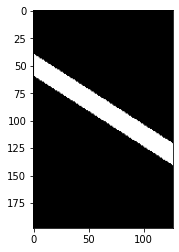

In [29]:
Frequency = 350e3  # Hz
WaterSOS = 1500 # m/s - water
WaterDensity=1000 # kg/m3

#Acryic
SolidLSOS = 2848 # m/s - 
SolidsSOS = 1026 # m/s - 
SolidDensity=1190 # kg/m3
SolidLAlpha = 34 # Np/m 
SolidSAlpha= 163 # Np/m 

ShortestWavelength =SolidsSOS / Frequency
SpatialStep =ShortestWavelength / 6.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.05,0.05,0.085])  # in m, x,y,z  # in m, x,y,z

TxRadius = 0.04 # m, 
TxDiameter=0.04
PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, HIGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/(np.mean([SolidsSOS,WaterSOS])) #time to cross one corner to another
TemporalStep=5e-8 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((2,5)) # two materials in this example
MaterialList[0,0]=WaterDensity # water density
MaterialList[0,1]=WaterSOS # water SoS

MaterialList[1,0]=SolidDensity # plastic density
MaterialList[1,1]=SolidLSOS # plastic long. SoS
MaterialList[1,2]=SolidsSOS # plastic shear SoS
MaterialList[1,3]=SolidLAlpha # plastic long. attenuation
MaterialList[1,4]=SolidSAlpha # plastic shear attenuation

#we define two - half spaces

AngleInterface=np.deg2rad(40)
m=np.sin(AngleInterface)
NY3=(N1-1)*m
r0=np.array([(N3/2)-60,(N3/2)-60+NY3,(N3/2)+NY3-40, (N3/2)-40])+0.5
p0=np.array([0.5,N1-0.5,N1-0.5,0.5])
rrcc=polygon(p0,r0)
mm=polygon2mask((N1,N3),np.vstack((p0,r0)).T)

MaterialMap[:,:,:]=np.tile(np.reshape(mm,[N1,1,N3]),[1,N2,1])

plt.figure()
plt.imshow(MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray);

#all other parameters are set to 0 


We apply the concepts on directivity to model a spherical cap for a focusing source. Below there is a function that uses scikit-image to prepare the mask of a spherical cap and how we can prepare correctly the directivity of each entry in the source mask.

In [30]:
def MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,Angle):
    #simple defintion of a focusing source centred in the domain, 
    #please note this is not a bullet-proof solution as it may not work for all cases
    XDim=np.arange(N1)*SpatialStep
    YDim=np.arange(N2)*SpatialStep
    ZDim=np.arange(N3)*SpatialStep
    XDim-=XDim[int(N1/2)]
    YDim-=YDim[int(N2/2)]
    ZDim-=ZDim[int(N3/2)]
    XX,YY,ZZ=np.meshgrid(YDim,XDim,ZDim)#note we have to invert this because how meshgrid works
    Depth=np.sqrt(TxRadius**2-(TxDiameter/2.0)**2)
    cX=int(N1/2)
    cZ=int(N3/2)
    
    MaskSource=np.zeros((N1,N2,N3),np.bool)
    FillMask=np.zeros((N1,N2,N3))
    
    for n,y in enumerate(YDim):
        if np.abs(y)<TxRadius:
            cDiam=int(np.ceil(TxRadius*np.sin(np.arccos(y/TxRadius))/SpatialStep))
            rr, cc = circle_perimeter(cX,cZ,cDiam,shape=(N1,N3))
            MaskSource[rr,n,cc]=np.True_
            rr,cc=disk((cX,cZ),cDiam+1,shape=(N1,N3))
            FillMask[rr,n,cc]=1
            
    
    FillMask[ZZ<=-Depth]=0.
    #instead of rotating the arc, we rotate the mask that will negate the perimeter to be turned off
    if Angle!=0.:
        for n in range(N2):
            FillMask[:,n,:]=rotate(FillMask[:,n,:],Angle,preserve_range=True)
        
    MaskSource[FillMask!=0]=False
        
    #since the sphere mask is 0-centred, the orientation vectors in each point is straighforward
    OxOyOz=np.vstack((-XX.flatten(),-YY.flatten(),-ZZ.flatten())).T
    #and we just normalize
    OxOyOz/=np.tile( np.linalg.norm(OxOyOz,axis=1).reshape(OxOyOz.shape[0],1),[1,3])
    Ox=OxOyOz[:,1].reshape(XX.shape) 
    Oy=OxOyOz[:,0].reshape(XX.shape)
    Oz=OxOyOz[:,2].reshape(XX.shape)
    Ox[MaskSource==False]=0
    Oy[MaskSource==False]=0
    Oz[MaskSource==False]=0
    return MaskSource.astype(np.uint32),Ox,Oy,Oz

We use a rotated focusing source so we can analyze the multiple stress that are generated once the acoustic beam reaches the solid. This time we show both source and layered material to verify the source does not overlap.

invalid value encountered in true_divide


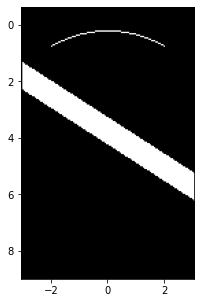

In [31]:
SourceMap,Ox,Oy,Oz=MakeFocusingSource(N1,N2,N3,SpatialStep,TxRadius,TxDiameter,0)
XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T+MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);

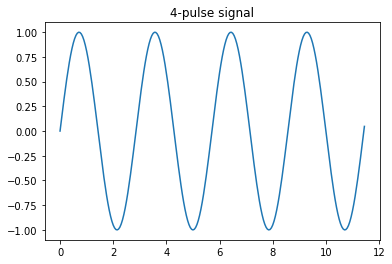

In [32]:
LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

In [33]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

### Collect stress data
So far in the previous examples, we have collected only particle displacement, this time we will specify to collect stress data both for 3D maps and sensor data

In [34]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         SelMapsSensorsList=['Vx','Vy','Vz',
                                                                            'Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz'],
                                                         SensorSteps=4,
                                                         TypeSource=0)

VLongInput,VShearInput [1500. 2848.] [   0. 1026.]
Q_cw_factor_long,Q_cw_factor_shear [0.96040047 1.        ] [0.92848006 1.        ]
VLongMat,VShearMat [1500.         2735.22055196] [  0.        952.6205461]
8.049638510888213e-08
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 7.969142125779331e-08 [1500.         2735.22055196] [  0.        952.6205461] [0.         0.15950179] [0.         0.29213381] [4.54728409e-07] [1500. 2848.] [   0. 1026.]
Matrix size= 127 x 127 x 198 , spatial resolution = 0.000488571, time steps = 1099, temporal step = 7.96914e-08, total sonication length 8.75429e-05 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=0
SizePMLxp1=0
SizePMLyp1=0
SizePMLzp1=0
SizePMLxp1yp1zp1=0
 Staggered FDTD - compiled at Jan  6 2021 - 15:14:59
N1, N2,N3 , ZoneCount and DT= 127,127,198,7.96914e-08
Number of sensors , timesteps for sensors and total maps= 17922, 275, 9
before cudaGetDeviceCount 
after cudaGetDeviceCount 
The

### Ploting data

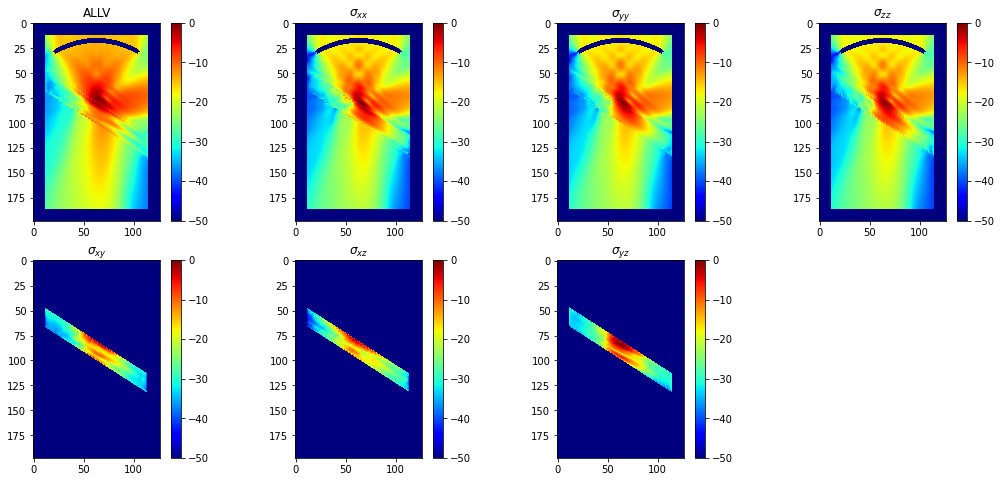

In [35]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1


### Plot sensor data maps over time
As we collected sensor data for $V_x$, $V_y$, $V_y$, $\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{zz}$, $\sigma_{xy}$, $\sigma_{xz}$, and $\sigma_{xz}$ , we can plot them using a widget to scroll the data over time

In [36]:
class ShowTimeData(object):
    def __init__(self,N1,N2,N3,InputParam,SourceMap,Sensor,Skip=1):
        nL=Sensor['Vx'].shape[1]
        IndTime=np.arange(0,nL,Skip)
        SensorPlane={}
        for k in Sensor:
            if k=='time':
                continue
            SensorPlane[k]=np.zeros((N1,N3,len(IndTime)))
        BInd=[]
        for n, index in enumerate( InputParam['IndexSensorMap']): 
            k=int(index/(N1*N2))
            j=int(index%(N1*N2))
            i=int(j%N1)
            j=int(j/N1)
            BInd.append([i,j,k])
        BInd=np.array(BInd)
        for k in SensorPlane:
            for nt,et in enumerate(IndTime):
                SensorPlane[k][BInd[:,0],BInd[:,2],nt]=Sensor[k][:,et]
            if 'Sigma' in k:
                SensorPlane[k]/=1e5
        self.SensorPlane=SensorPlane
        self.fig=None
        
    def PlotTimePoint(self,timep=0):
        if self.fig:
            plt.close(self.fig)
        
        self.fig=plt.figure(figsize=(16,9))
        n=1
        for k in  self.SensorPlane:
            plt.subplot(3,3,n)
            plt.imshow(self.SensorPlane[k][:,:,timep].T,cmap=plt.cm.jet)
            plt.colorbar()
            n+=1
            if 'V' in k:
                plt.title('$V_'+k.split('V')[1]+'$')
            else:
                plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
        plt.show()
        
    def SelectTimePoint(self):
        Sel=IntSlider(description='Time point',value=0,
                        min=0,max=self.SensorPlane[list(self.SensorPlane.keys())[0]].shape[2]-1,step=1,continuous_update=False,
                        layout=Layout(width='75%'),style={'description_width': 'initial'})
        interact(self.PlotTimePoint,timep=Sel)
       
        

In [37]:
ShowTimeData(N1,N2,N3,InputParam,SourceMap,Sensor).SelectTimePoint()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time point', layout=Layout(widt…

Because the orientation of the transducer rotated along the $Y$ axis, we can clearly see the P-wave (faster and with longer wavelength) in $\sigma_{xx}$ and $\sigma_{zz}$, and the S-wave (slower and with shorter wavelength) in $\sigma_{xy}$, $\sigma_{xz}$, $\sigma_{yz}$

# Superposition method

In practice, the superposition method consist in combining multiple simulation at low-resolution where each simulation uses a water-solid domain that depends on the level of intersection of the ideal plane representing the water-solid interface.

In our example we can plot the *ideal* boundary between the water-solid media.

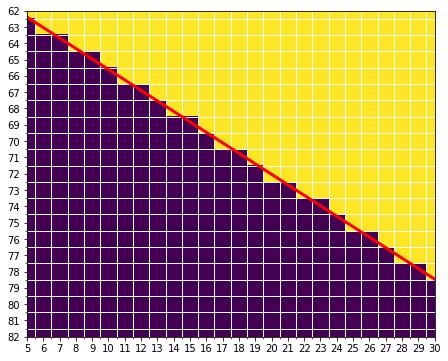

In [38]:
plt.figure(figsize=(8,6))
plt.imshow(MaterialMap[:,int(N2/2),:].T);
plt.plot(p0,r0,'r',linewidth=3)
ax = plt.gca();
ax.set_xticks(np.arange(0, N1, 1));ax.set_yticks(np.arange(0, N3, 1))
ax.set_xticks(np.arange(-.5, N1, 1), minor=True);ax.set_yticks(np.arange(-.5, N3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
plt.ylim(82,62);plt.xlim(5,30);ax.set_aspect(1)


We can see that voxels that are roughly 50% or more below the line (<span style="color:red">red</span>) of interface are considered solid (<span style="color:yellow;background-color:black">yellow</span>) while if less of 50% are considered water (<span style="color:purple">purple</span>). However, a more appropriate approach would be to consider the real fraction of solid of voxel inside the region defined as solid.

The superposition method solves this problem by running `N` simulations where voxels are classified either solid or water using the following pseudocode
```
for n=1 to N
    for all voxels
        if G(voxel) < n/N
            voxel is consider solid
        else
            voxel is considered water
```
where `G` is the fraction of the voxel inside the region considered as solid. If we run `N=10` simulations, a voxel that has a fraction around 0.3 will be included 3 times as solid (and 7 as water), while a voxel that has a fraction 0.7 will be included 7 times as solid (and 3 as water), and so on. The final result of the simulation is the average of the temporal signals of the `N` simulations.

### Use of constructive solid geometry (CSG) to calculate solid fraction of `G` of voxels

We will use CSG to calculate the fraction `G`. First, we use simply morphological operations to find the voxels that surround the boundary line.

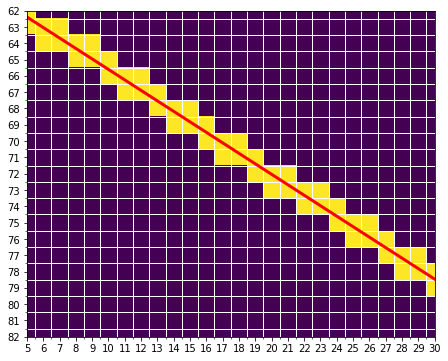

In [39]:
SolidRegion=MaterialMap!=0
SolidRing=np.logical_xor(ndimage.morphology.binary_dilation(SolidRegion),ndimage.morphology.binary_erosion(SolidRegion))

plt.figure(figsize=(8,6))
plt.imshow(SolidRing[:,int(N2/2),:].T*5);
plt.plot(p0,r0,'r',linewidth=3)
ax = plt.gca();
ax.set_xticks(np.arange(0, N1, 1));ax.set_yticks(np.arange(0, N3, 1))
ax.set_xticks(np.arange(-.5, N1, 1), minor=True);ax.set_yticks(np.arange(-.5, N3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
plt.ylim(82,62);plt.xlim(5,30);ax.set_aspect(1)


As the solid layer is relatively simple, we can use a delaunay operation to build a 3D object. We can use the interactive visualization tools from `pyvistaqt` to inspect the solid object.

In [40]:
iring,jring,kring=np.where(SolidRing)
SolidVertices=np.vstack((np.vstack((p0,np.ones(4)*0.5,r0)).T,np.vstack((p0,np.ones(4)*N2-0.5,r0)).T))
cloud = pv.PolyData(SolidVertices)
meshSolid = cloud.delaunay_3d().extract_surface()
tetSolid = pymesh.form_mesh(meshSolid.points,meshSolid.faces.reshape(-1, 4)[:, 1:]);
pla=pv.PlotterITK()
pla.add_mesh(meshSolid)
pla.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### CSG boolean intersection
The CSG operation is computionally intense, it takes a few minutes to complete. We can use the libray `pymp` to run the task in parallel, but still it will take some time. Even if this may look as a detriment, it still remains that other techniques or libraries can be explored to calculate this step. Also, for many FDTD simulations, this step will need to be run only once or very few times depending on the conditions.

Also, for simple cases like this, you can use 2D CSG operations (also available in `pymesh`) that are much faster. The purpose to use a 3D CSG operation is to provide a framework for users that can adapt for their needs.

For simplicity purposes, we are going to load a precalculate result. 

In [41]:
bRecalculate=True
if bRecalculate:
    GMap=(MaterialMap>0)*1.0
    GResults = pymp.shared.array((iring.shape[0]))
    with pymp.Parallel(4) as p:
        for n in p.range(0, iring.shape[0]):

            i=iring[n]
            j=jring[n]
            k=kring[n]
            im=i-0.5
            ip=i+0.5
            jm=j-0.5
            jp=j+0.5
            km=k-0.5
            kp=k+0.5
            pp=np.zeros((8,3))
            pp[0,:]=[im,jm,km]
            pp[1,:]=[ip,jm,km]
            pp[2,:]=[ip,jp,km]
            pp[3,:]=[im,jp,km]
            pp[4,:]=[im,jm,kp]
            pp[5,:]=[ip,jm,kp]
            pp[6,:]=[ip,jp,kp]
            pp[7,:]=[im,jp,kp]

            cloudC = pv.PolyData(pp)
            meshCube = cloudC.delaunay_3d().extract_surface()

            tetCube = pymesh.form_mesh(meshCube.points,meshCube.faces.reshape(-1, 4)[:, 1:]);
            GResults[n] =pymesh.boolean(tetCube, tetSolid,"intersection",engine="igl").volume
            if (n%5000==0):
                p.print(n,len(iring))
        
    for i,j,k,n in zip(iring,jring,kring,range(iring.shape[0])):
            GMap[i,j,k]=GResults[n]       
            
    np.savez_compressed('GMAPSolid',GMap=GMap)
else:
    GMap=np.load('GMAPSolid.npz')['GMap']

0 75584
5000 75584
10000 75584
15000 75584


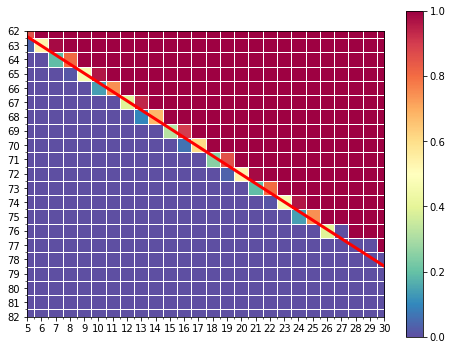

In [42]:
plt.figure(figsize=(8,6))
plt.imshow(GMap[:,int(N2/2),:].T,cmap=plt.cm.Spectral_r);
plt.plot(p0,r0,'r',linewidth=3)
ax = plt.gca();
ax.set_xticks(np.arange(0, N1, 1));ax.set_yticks(np.arange(0, N3, 1))
ax.set_xticks(np.arange(-.5, N1, 1), minor=True);ax.set_yticks(np.arange(-.5, N3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
plt.ylim(82,62);plt.xlim(5,30);ax.set_aspect(1)
plt.colorbar();

We can see how the CSG operation did an accurate result to produce the fraction of each voxel being intersected by the ideal water-solid boundary.

---


In [43]:
SensorSPP,LastMapSPP,DictRMSValueSPP,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=1,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz'],
                                                         DefaultGPUDeviceName='SUPER',
                                                         SelMapsSensorsList=['Vx','Vy','Vz',
                                                                            'Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz'],
                                                         SensorSteps=4,
                                                         TypeSource=0,
                                                         SPP_ZONES=8, # we add these extra parameters
                                                         SPP_VolumeFraction=GMap)

VLongInput,VShearInput [1500. 2848.] [   0. 1026.]
Q_cw_factor_long,Q_cw_factor_shear [0.96040047 1.        ] [0.92848006 1.        ]
VLongMat,VShearMat [1500.         2735.22055196] [  0.        952.6205461]
8.049638510888213e-08
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 7.969142125779331e-08 [1500.         2735.22055196] [  0.        952.6205461] [0.         0.15950179] [0.         0.29213381] [4.54728409e-07] [1500. 2848.] [   0. 1026.]
We will use SPP
Matrix size= 127 x 127 x 198 , spatial resolution = 0.000488571, time steps = 1099, temporal step = 7.96914e-08, total sonication length 8.75429e-05 
Performing Simulation wtih GPU CUDA
Running with new interface conditions
SizePML=0
SizePMLxp1=0
SizePMLyp1=0
SizePMLzp1=0
SizePMLxp1yp1zp1=0
 Staggered FDTD - compiled at Jan  6 2021 - 15:14:59
N1, N2,N3 , ZoneCount and DT= 127,127,198,7.96914e-08
Number of sensors , timesteps for sensors and total maps= 17922, 275, 9
before cudaGetDeviceCount 
after cudaGet

### Ploting data

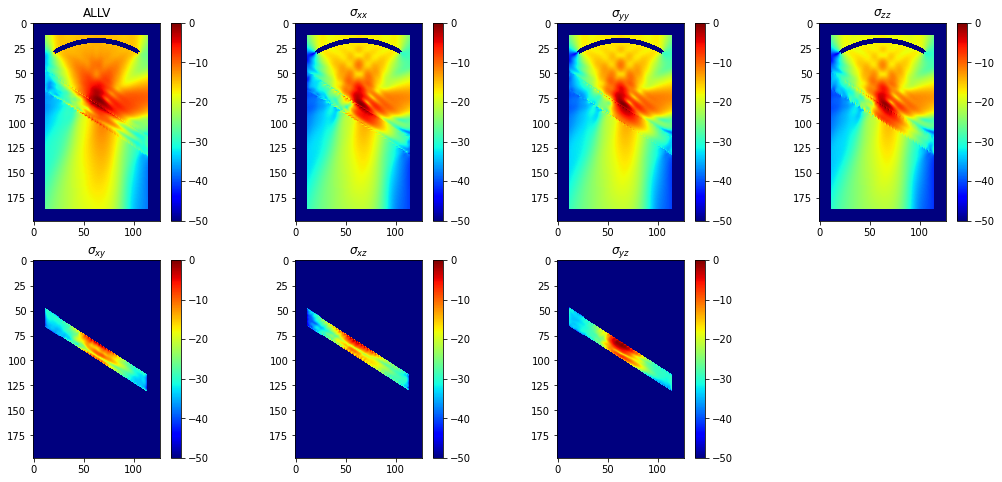

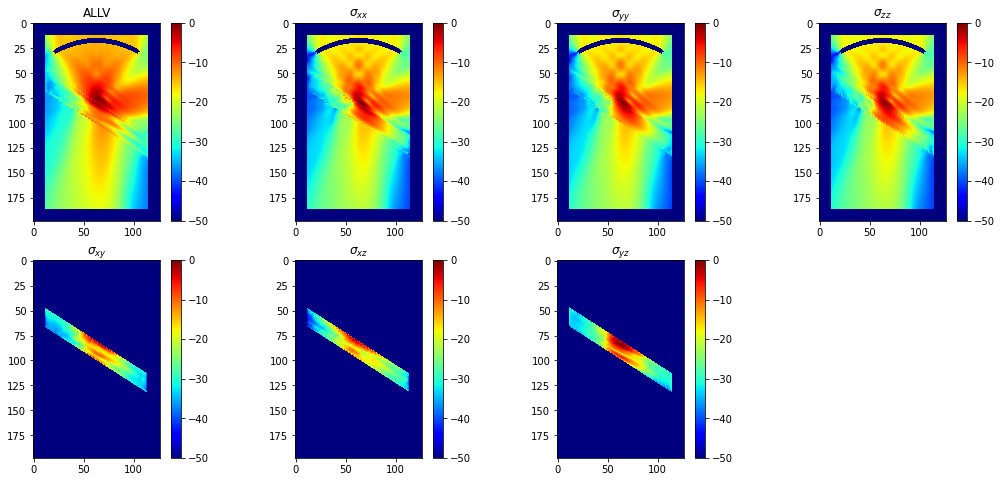

In [44]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValueSPP.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1